In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pickle
import random
from PIL import Image
from math import *

In [2]:
def tensor_imshow(im_tensor,cannel):
    b,c,h,w=im_tensor.shape
    if c==1:
        plt.imshow(im_tensor.squeeze().detach().numpy())
    else:
        plt.imshow(im_tensor.squeeze().detach().numpy()[cannel,:])
        
def get_training_fragment(frag_size,im):
    h,w,c=im.shape
    n=random.randint(0,int(h/frag_size)-1)
    m=random.randint(0,int(w/frag_size)-1)
    
    shape=frag_size/4
    vt_h=math.ceil((h+1)/shape)
    vt_w=math.ceil((w+1)/shape)
    vt=np.zeros([vt_h,vt_w])
    vt_h_po=round((vt_h-1)*(n*frag_size/(h-1)+(n+1)*frag_size/(h-1))/2)
    vt_w_po=round((vt_w-1)*(m*frag_size/(w-1)+(m+1)*frag_size/(w-1))/2)
    vt[vt_h_po,vt_w_po]=1
    vt = np.float32(vt)
    vt=torch.from_numpy(vt.reshape(1,1,vt_h,vt_w))
    
    return im[n*frag_size:(n+1)*frag_size,m*frag_size:(m+1)*frag_size,:],vt

def write_result_in_file(file_name):
    n=0
    with open(filename,'w') as file:
        for i in range(len(result)):
            while n<result[i][0]:
                s=str(n)
                n=n+1
                s=s+"\n"
                file.write(s)
            s=str(result[i][0])+" "+str(result[i][1])+" "+str(result[i][2])+" "+str(result[i][3])
            s=s+"\n"
            n=n+1
            file.write(s)
        file.close()
    
    
def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().numpy()
    score=sum(sum(map_corre))
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return score,coordonnee[0].mean()/h,coordonnee[1].mean()/w
    """
    if len(coordonnee[0])==1:
        h_=coordonnee[0][0]/h
        w_=coordonnee[1][0]/w
        return max_value,h_,w_
    else:
        return -1,-1,-1
    """

def test_fragment32_32(frag,seuillage):
    a=frag[:,:,0]+frag[:,:,1]+frag[:,:,2]
    mask = (a == 0)
    arr_new = a[mask]
    if arr_new.size/a.size<=(1-seuillage):
        return True
    else:
        return False
    
def patch_rotated_mask(frag_size):
    Mask=np.ones([frag_size,frag_size,3],dtype='uint8')
    Im_Mask=Image.fromarray(Mask)
    for i in range(18):
        Im=Im_Mask.rotate(20*i)
        m=np.array(Im)
        Mask=Mask*m
    return Mask

def save_net(file_path,net):
    pkl_file = open(file_path, 'wb')
    pickle.dump(net,pkl_file)
    pkl_file.close()
    
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

In [3]:
def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]

def shift_1pixel(map_corr,num_patch):
    #num_patch:
    #          0 1
    #          2 3
    h,w=map_corr.shape
    map_shifted=torch.zeros([h,w])
    if num_patch==0:
        map_shifted[1:h,1:w]=map_corr[0:h-1,0:w-1]
    if num_patch==1:
        map_shifted[1:h,0:w-1]=map_corr[0:h-1,1:w]
    if num_patch==2:
        map_shifted[0:h-1,1:w]=map_corr[1:h,0:w-1]
    if num_patch==3:
        map_shifted[0:h-1,0:w-1]=map_corr[1:h,1:w]
        
    return map_shifted

def shift_map_corre(n,m,map_corre):
    b,c,h,w=map_corre.shape
    for i in range(n):
        for j in range(m):
            if i%2==0 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],0)
            if i%2==0 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],1)
            if i%2==1 and j%2==0:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],2)
            if i%2==1 and j%2==1:
                map_corre[0,i*m+j,:,:]=shift_1pixel(map_corre[0,i*m+j,:,:],3)
    return map_corre

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #n*m patches
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        #self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
        
        
    def get_descripteur(self,img,using_cuda):
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        #shift
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        map_corre=map_corre/(map_corre.max())
        return map_corre

In [90]:
def get_patch_list(frag,frag_size,seuillage):
    n_=0
    m_=0
    h,w,c=frag.shape
    patch_list=[]
    position_list=[]
    i=0
    for i in range(4):
        n=n_+i*4
        while n+frag_size<h:
            m=m_+i*4
            while m+frag_size<w:
                patch=frag[n:n+frag_size,m:m+frag_size,:]
                if test_fragment32_32(patch,seuillage):
                    patch_list.append(patch)
                    position_list.append([int(n+frag_size/2),int(m+frag_size/2)])
                m=m+frag_size
            n=n+frag_size
    return patch_list,position_list

In [47]:
def run_net(net,img,frag,frag_size,using_cuda,rotation):
    Img=Image.fromarray(frag)
    frag=np.array(Img.rotate(rotation))
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    seuillage=20 #au moin 20 patchs dans les fragments
    limite=4
    frag_list=[]
    position_frag=[]
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.5):
                frag_list.append(frag_32)
                position_frag.append([i*frag_size+frag_size/2,j*frag_size+frag_size/2])
    img_tensor=img2tensor(img)
    
    for l in range(limite):
        if len(frag_list)>=seuillage:
            break
        else:
            for i in range(n-1):
                for j in range(m-1):
                    frag_32=frag[i*frag_size+(l+1)*4:(i+1)*frag_size+(l+1)*4,j*frag_size+(l+1)*4:(j+1)*frag_size+(l+1)*4]
                    if test_fragment32_32(frag_32,0.5):
                        frag_list.append(frag_32)
                        position_frag.append([(i*frag_size+frag_size/2)+(l+1)*4,(j*frag_size+frag_size/2)+(l+1)*4])

    if using_cuda:
        img_tensor=img_tensor.cuda()
    
    score_list=[]
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        score,po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
        score_list.append(score)
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x0=position_frag[i][0]
        y0=position_frag[i][1]
        x1=int(round(h_img*coordonnee_list[i][0]))
        y1=int(round(w_img*coordonnee_list[i][1]))
        position.append([x0,y0,x1,y1])
    return score_list,position

In [102]:
def run_net_v3(net,img,frag,frag_size,seuillage,using_cuda,rotation):
    img_tensor=img2tensor(img)
    frag_list,position_frag=get_patch_list(frag,frag_size,seuillage)
    if using_cuda:
        img_tensor=img_tensor.cuda()
    
    score_list=[]
    coordonnee_list=[]
    for i in range(len(frag_list)):
        frag_tensor=img2tensor(frag_list[i])
        if using_cuda:
            frag_tensor=frag_tensor.cuda()
        res=net.forward(img_tensor,frag_tensor,using_cuda)
        if using_cuda:
            res=res.cpu()
        score,po_h,po_w=show_coordonnee(res)
        coordonnee_list.append([po_h,po_w])
        score_list.append(score)
    h_img,w_img,c=img.shape
    position=[]
    for i in range(len(coordonnee_list)):
        x0=position_frag[i][0]
        y0=position_frag[i][1]
        x1=int(round(h_img*coordonnee_list[i][0]))
        y1=int(round(w_img*coordonnee_list[i][1]))
        position.append([x0,y0,x1,y1])
    return score_list,position

In [5]:
def creer_rotate_patch(frag,frag_size):
    Img_frag=Image.fromarray(frag)
    Mask=patch_rotated_mask(frag_size)
    frag_rotate=frag*Mask
    for i in range(18):
        Img_frag_rotate=Img_frag.rotate(i*20)
        patch=np.array(Img_frag_rotate)
        frag_rotate=np.concatenate((frag_rotate,patch*Mask),axis=0)
    return frag_rotate

In [6]:
def run_net_v2(net,img,frag,frag_size,using_cuda): #chaque patch dans frag a une rotation plus possible
    h,w,c=frag.shape
    n=int(h/frag_size)
    m=int(w/frag_size)
    frag_list=[]
    position_frag=[]
    for i in range(n):
        for j in range(m):
            frag_32=frag[i*frag_size:(i+1)*frag_size,j*frag_size:(j+1)*frag_size]
            if test_fragment32_32(frag_32,0.9):
                frag_list.append(frag_32)
                position_frag.append([i*frag_size+frag_size/2,j*frag_size+frag_size/2])
    score_list=[]
    position_list=[]
    rotate=[]
    for i in range(len(frag_list)):
        frag_rotate=creer_rotate_patch(frag_list[i],frag_size)
        score,position=run_net(net,img,frag_rotate,frag_size,using_cuda,0)
        
        if len(score)>0:
            meilleur=np.where(score==min(score))[0][0]
            score_list.append(score[meilleur])
            rotate.append(meilleur*20)
            position_list.append([position_frag[i][0],position_frag[i][1],position[meilleur][2],position[meilleur][3]])
    return score_list,position_list,rotate

In [7]:
def get_rotate_patch(frag,frag_size,rotation):
    Img_frag=Image.fromarray(frag)
    frag_rotate=np.array(Img_frag.rotate(rotation))
    patch,vt=get_training_fragment(frag_size,frag_rotate)
    
    while test_fragment32_32(patch,1)==False:
        patch,vt=get_training_fragment(frag_size,frag_rotate)
        
    patch_rotate=patch
    for i in range(20):
        patch,vt=get_training_fragment(frag_size,frag_rotate)
        while test_fragment32_32(patch,1)==False:
            patch,vt=get_training_fragment(frag_size,frag_rotate)
        patch_rotate=np.concatenate((patch_rotate,patch),axis=0)
    return patch_rotate

In [8]:
def get_rotate_patch_(frag,frag_size):
    
    patch,vt=get_training_fragment(frag_size,frag)
    Mask=patch_rotated_mask(frag_size)
    while test_fragment32_32(patch,0.7)==False:
        patch,vt=get_training_fragment(frag_size,frag)
    patch_rotate=patch*Mask
    Image_patch=Image.fromarray(patch)
    for i in range(18):
        Image_patch_rotate=Image_patch.rotate(i*20)
        patch=np.array(Image_patch_rotate)
        patch_rotate=np.concatenate((patch_rotate,patch*Mask),axis=0)
    return patch_rotate

In [9]:
def trouver_rotate(net,frag,img,frag_size,using_cuda):
    rotation=[]
    for i in range(18):
        frag_rotate=get_rotate_patch(frag,frag_size,i*20)
        score,position=run_net(net,img,frag_rotate,frag_size,using_cuda,0)
        rotate=sum(score)/len(score)
        rotation.append(rotate)
    return rotation

In [10]:
def creer_point(x,y):
    p=np.zeros((3,1))
    p[0][0]=x
    p[1][0]=y
    p[2][0]=1
    return p

def selectionner_points(n,M):
    table=[]
    for i in range(M):
        table.append(i)
    result=[]
    for i in range(n):
        index=random.randint(0,M-i-1)
        result.append(table[index])
        table[index]=table[M-1-i]
    return result

def position_rotation(h,centre_frag):
    centre=h@centre_frag
    cos_rot=(h[0][0]+h[1][1])/2
    sin_rot=(h[1][0]-h[0][1])/2
    tan_rot=sin_rot/(cos_rot+0.0000001)
    if cos_rot>0:
        rot_frag=math.atan(tan_rot)*(180/pi)
    else:
        rot_frag=math.atan(tan_rot)*(180/pi)+180
    rot_frag=-rot_frag
    if rot_frag>0:
        rot_frag-=360
    return centre[0][0],centre[1][0],rot_frag

def test_frag(inline,frag,fres):
    itera=10
    frag_inline=[]
    fres_inline=[]
    for i in range(np.size(inline,0)):
        if inline[i]==1:
            frag_inline.append([frag[i][0],frag[i][1]])
            fres_inline.append([fres[i][0],fres[i][1]])
    p=[]
    for i in range(itera):
        point_test=selectionner_points(2,np.size(frag_inline,0))
        diff_x_frag=frag_inline[point_test[1]][0]-frag_inline[point_test[0]][0]
        diff_y_frag=frag_inline[point_test[1]][1]-frag_inline[point_test[0]][1]
        diff_frag=sqrt(pow(diff_x_frag,2)+pow(diff_y_frag,2))
        
        diff_x_fres=fres_inline[point_test[1]][0]-fres_inline[point_test[0]][0]
        diff_y_fres=fres_inline[point_test[1]][1]-fres_inline[point_test[0]][1]
        diff_fres=sqrt(pow(diff_x_fres,2)+pow(diff_y_fres,2))
        if diff_frag !=0:
            fsf=diff_fres/diff_frag
            p.append([fsf])
        result=np.mean(p)
    return result

def frag_match(frag,img,position):
    
    frag_size=frag.shape
    centre_frag=creer_point(frag_size[0]/2,frag_size[1]/2)
    
    retained_matches = []
    frag=[]
    fres=[]
    
    for i in range(len(position)):
        frag.append([float(position[i][0]),float(position[i][1])])
        fres.append([float(position[i][2]),float(position[i][3])])
    
    if np.size(frag)>0:
        h,inline=cv2.estimateAffinePartial2D(np.array(frag),np.array(fres))
        if np.size(h)!=6:
             return ([-1])
        else:
            x,y,rot=position_rotation(h,centre_frag)
            pourcenttage=sum(inline)/np.size(frag,0)
            
            if sum(inline)>3:
                p=test_frag(inline,frag,fres)
                if abs(p-1)<0.3:
                    return([round(y),round(x),round(rot,3)])
                else:
                    return ([-2])
            else:
                return ([-3])
    else:
        return ([-4])     

In [11]:
if __name__=="__main__":
    frag_size=16
    using_cuda=True
    net=load_net("./Training_300_fresque0")
    img_test=cv2.imread("./fresque0.ppm")
    result=[]
    for n in range(315):
        if n<10:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_000"+str(n)+".ppm")
        elif n<100:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_00"+str(n)+".ppm")
        else:
            frag_test=cv2.imread("./frag_eroded0/frag_eroded_0"+str(n)+".ppm")
        for i in range(18):
            score_list,position=run_net(net,img_test,frag_test,frag_size,using_cuda,20*i)
            frag_position=frag_match(frag_test,img_test,position)
            if len(frag_position)==3:
                rotation_base=i*20
                break
        if len(frag_position)==3:
            frag_position[2]=rotation_base-360-frag_position[2]
            if frag_position[2]>0:
                frag_position[2]=frag_position[2]-360
            result.append([n,frag_position[0],frag_position[1],round(frag_position[2],3)])
            
    filename="result_fresque0.txt"
    write_result_in_file(filename)

KeyboardInterrupt: 

[[0, 520.0, 575.0, -356.273],
 [1, 535.0, 460.0, -113.382],
 [2, 971.0, 272.0, -41.604],
 [3, 1641.0, 650.0, -120.113],
 [4, 1326.0, 177.0, -137.827],
 [5, 1412.0, 70.0, -129.616],
 [6, 106.0, 521.0, -73.106],
 [7, 420.0, 440.0, -175.011],
 [8, 287.0, 532.0, -300.591],
 [9, 1518.0, 167.0, -291.317],
 [10, 231.0, 429.0, -181.722],
 [11, 666.0, 483.0, -230.13],
 [12, 855.0, 104.0, -347.334],
 [13, 1267.0, 88.0, -309.066],
 [14, 129.0, 256.0, -211.853],
 [15, 924.0, 120.0, -146.175],
 [16, 655.0, 372.0, -174.966],
 [17, 1410.0, 528.0, -329.194],
 [19, 632.0, 268.0, -87.479],
 [20, 1344.0, 579.0, -321.669],
 [21, 1571.0, 95.0, -272.511],
 [22, 54.0, 94.0, -72.134],
 [23, 864.0, 258.0, -70.111],
 [24, 1201.0, 26.0, -77.263],
 [25, 812.0, 537.0, -4.631],
 [26, 29.0, 723.0, -284.621],
 [27, 1411.0, 199.0, -324.116],
 [28, 769.0, 595.0, -340.239],
 [29, 361.0, 435.0, -349.833],
 [30, 1264.0, 731.0, -211.99],
 [31, 957.0, 739.0, -356.092],
 [32, 1308.0, 679.0, -144.854],
 [33, 705.0, 553.0, -20

In [14]:

score_list,position=run_net(net,img_test,frag_test,frag_size,using_cuda,20*i)

In [15]:
frag_position

-2

In [150]:
frag_test=cv2.imread("./frag_eroded0/frag_eroded_0001.ppm")

In [49]:
len(position)

59

In [14]:
frag_position

[-3]

In [145]:
img_show=cv2.imread("./fresque0.ppm")
h,w,c=img_test.shape
position_show=np.zeros([h,w,c])

In [146]:
for i in range(len(position)):
    position_show[position[i][2]-5:position[i][2]+5,position[i][3]-5:position[i][3]+5,:]=255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


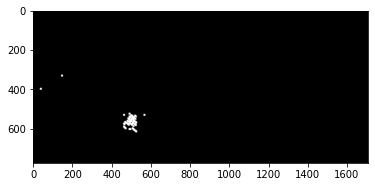

In [147]:
plt.imshow(position_show)

In [134]:
position

[[40, 88, 735, 244],
 [40, 104, 24, 1623],
 [56, 40, 439, 1263],
 [56, 72, 739, 240],
 [56, 88, 767, 256],
 [56, 104, 595, 536],
 [56, 120, 635, 652],
 [72, 24, 443, 1261],
 [72, 40, 767, 64],
 [72, 56, 635, 652],
 [72, 72, 767, 256],
 [72, 88, 739, 244],
 [72, 104, 20, 1695],
 [72, 120, 635, 652],
 [88, 24, 220, 1143],
 [88, 40, 499, 748],
 [88, 56, 515, 1083],
 [88, 72, 727, 196],
 [88, 88, 739, 244],
 [88, 104, 767, 256],
 [88, 120, 767, 256],
 [104, 40, 703, 268],
 [104, 56, 767, 64],
 [104, 72, 144, 88],
 [120, 40, 435, 1263],
 [120, 72, 272, 208],
 [120, 88, 607, 392],
 [120, 120, 607, 392],
 [44, 60, 755, 228],
 [44, 92, 739, 244],
 [44, 108, 763, 64],
 [60, 44, 767, 360],
 [60, 76, 763, 264],
 [60, 92, 767, 256],
 [60, 108, 647, 608],
 [76, 28, 519, 1075],
 [76, 44, 767, 64],
 [76, 60, 655, 1307],
 [76, 76, 767, 208],
 [76, 92, 763, 256],
 [76, 108, 539, 516],
 [76, 124, 627, 476],
 [92, 28, 763, 64],
 [92, 44, 499, 724],
 [92, 60, 635, 652],
 [92, 76, 767, 204],
 [92, 92, 767,

In [19]:
frag_test.shape

(44, 46, 3)

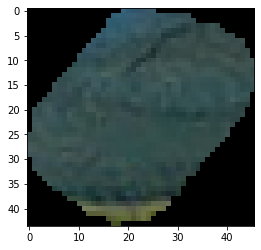

In [20]:
plt.imshow(frag_test)

In [91]:
patch_list,position_list=get_patch_list(frag_test,frag_size,1)

In [85]:
len(position_list)

119

In [148]:
frag_position=frag_match(frag_test,img_test,position)

In [149]:
frag_position

[521.0, 575.0, -3.956]

In [93]:
img_show=frag_test
for i in range(len(position_list)):
    img_show[position_list[i][0]-1:position_list[i][0]+1,position_list[i][1]-1:position_list[i][1]+1,:]=0

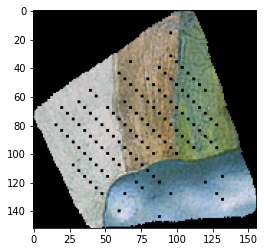

In [94]:
plt.imshow(img_show)

In [143]:
frag_test=cv2.imread("./frag_eroded0/frag_eroded_0000.ppm")
score,position=run_net_v3(net,img_test,frag_test,frag_size,1,using_cuda,0)


In [144]:
position

[[24, 56, 533, 500],
 [40, 40, 549, 486],
 [40, 56, 549, 502],
 [40, 72, 547, 516],
 [56, 24, 567, 470],
 [56, 40, 565, 486],
 [56, 56, 563, 502],
 [56, 72, 563, 518],
 [72, 40, 581, 488],
 [72, 56, 581, 504],
 [72, 72, 579, 520],
 [88, 24, 599, 472],
 [104, 72, 611, 522],
 [12, 12, 332, 148],
 [28, 60, 535, 504],
 [28, 76, 535, 520],
 [28, 124, 531, 568],
 [44, 44, 553, 490],
 [44, 60, 551, 506],
 [44, 76, 551, 522],
 [60, 28, 571, 474],
 [60, 44, 567, 492],
 [60, 60, 569, 508],
 [60, 76, 567, 524],
 [76, 76, 583, 524],
 [92, 44, 603, 492],
 [92, 60, 599, 508],
 [108, 76, 615, 526],
 [16, 16, 399, 40],
 [16, 48, 525, 492],
 [32, 48, 539, 492],
 [32, 64, 539, 508],
 [32, 80, 539, 524],
 [48, 48, 557, 494],
 [48, 64, 555, 510],
 [64, 16, 575, 464],
 [64, 32, 573, 478],
 [64, 48, 573, 494],
 [64, 64, 571, 510],
 [64, 80, 571, 526],
 [80, 16, 591, 464],
 [80, 64, 587, 512],
 [96, 48, 603, 496],
 [96, 64, 603, 512],
 [20, 20, 531, 464],
 [36, 52, 543, 496],
 [36, 68, 543, 512],
 [52, 36, 5

TypeError: Invalid shape (0,) for image data

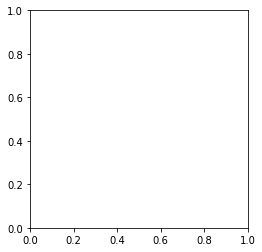

In [152]:

for i in range(18):
    score_list,position=run_net_v3(net,img_test,frag_test,frag_size,1,using_cuda,20*i)
    frag_position=frag_match(frag_test,img_test,position)
    if len(frag_position)==3:
        rotation_base=i*20
        break

In [153]:
frag_position

[-2]